#DayFilter Process Implementation on a Univariate Dataset of Chiller Plant Data

##Part 1 - Symbolic Aggregate Approximation to create `motif` and `discord` candidates

This analysis was prepared by [Clayton Miller](https://www.researchgate.net/profile/Clayton_Miller2)
as part of a series of Commercial Open Building Datasets on [datadrivenbuilding.org](http://datadrivenbuilding.org/) This notebook will implement the first part of the DayFilter Process on data from the [United World College of South East Asia Tampines Campus in Singapore](https://www.uwcsea.edu.sg/east-campus) tilizing the [United World College of South East Asia - Open data to faciliate research and development](http://datadrivenbuilding.org/United-World-College-Campus)

###The DayFilter Process is outlined an [Automation in Construction publication](https://www.researchgate.net/publication/266616977_Automated_daily_pattern_filtering_of_measured_building_performance_data) -- the dataset used in this notebook is identical to that illustrated in the paper.

##Goal of the Notebook
The purpose of `DayFilter` is the automate the process of simply characterizing different day-types accoding to the frequency or infrequency that they occur. Simply separating the *frequent behaviour* from the *infrequent behavior*

This dataset is downloadable [here](https://www.dropbox.com/s/30nkwi671ad6lpe/RawData.zip?dl=0) and is licensed under a [Creative Commons Attribution-NonCommercial 3.0 Unported License](http://creativecommons.org/licenses/by-nc/3.0/). 

First, we load the appropriate libaries -- including the following external (and very important libraries):
- [Pandas](http://pandas.pydata.org/)
- [matplotlib](http://matplotlib.org/)

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import string
%matplotlib inline
os.chdir(r'D:\1_project\datemining\DataMiningAndStatistical\data\UWC\SAX\RawData')

We need a function from the [Scipy](http://www.scipy.org/) library to do the SAX transformation:

In [13]:
from scipy.stats import norm

We'll also use the statistics visualization libary [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/):

In [14]:
import seaborn as sns

And we'll load the `custom.css` and `matplotlib` parameters to make the notebook a little more pretty -- if these files don't load properly, the visualiations will still work. These styling settings were shamelessly stolen from the awesome [Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) book and associated IPython notebooks.

In [4]:
from IPython.core.display import HTML
from IPython.core.display import Image 
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

FileNotFoundError: [Errno 2] No such file or directory: './styles/custom.css'

In [5]:
s = json.load(open("./styles/bmh_matplotlibrc.json"))
matplotlib.rcParams.update(s)

##Load and explore the data

First, we will load the univariate datapoint that we'd like to implement the process on: the whole building -- in this case it will be the whole chilled water plant kW power readings `"CP_TotalChiller_kW"`

In [15]:
chillerdata = pd.read_csv("./FullRawChillerPlantSystem.csv", index_col='Unnamed: 0', parse_dates=True)

In [16]:
df = chillerdata["CP_TotalChiller_kW"].truncate(before='2012-07-12').dropna()

In [17]:
df.head()

2012-07-12 00:00:00    0.0
2012-07-12 00:03:00    0.0
2012-07-12 00:06:00    0.0
2012-07-12 00:09:00    0.0
2012-07-12 00:12:00    0.0
Name: CP_TotalChiller_kW, dtype: float64

So, we have `304,471` points at 3 min intervals from July 12, 2012 to April 9, 2014. Let's visualize as a line chart

In [18]:
df.resample('D').head()

D:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


2012-07-12     96.616231
2012-07-13    137.107292
2012-07-14     19.259292
2012-07-15     11.711167
2012-07-16    133.032813
Freq: D, Name: CP_TotalChiller_kW, dtype: float64

This is 637 days worth of time-series performance data from the same chilled water plant in a tropical climate.

In [23]:
df.plot(c='k', figsize=(15,5))
plt.title("Chiller Plant UWC Tampines")
plt.xlabel("Time Range")
plt.ylabel("kW Chilled Water Demand")
plt.savefig("./graphics/rawdata_chillerkW_linechart.png")

If we look at a histogram of the daily data, we can understand frequency of each type of daily consumption. We average across hours and then sum across days to get an effective kWh from the instantaneous kW readings.

In [24]:
df.resample('H').resample('D', how='sum').hist(bins=20, figsize=(15,5))
plt.title("Chiller Plant UWC Tampines Histogram")
plt.xlabel("Daily Total kWh Consumption")
plt.ylabel("Number of Days")
plt.savefig("./graphics/rawdata_chillerkW_hist.png")

D:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':
D:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


Let's zoom into a month and aggregate to hourly data to smooth and get a closer look at the behaviour of the plant

In [25]:
df.resample('H').truncate(before='01-01-2013', after='02-01-2013').plot(c='k', figsize=(15,5))
plt.title("Chiller Plant UWC Tampines")
plt.xlabel("Time Range")
plt.ylabel("kW Chilled Water Demand")
plt.savefig("./graphics/rawdata_chillerkW_linechart_zoomedin.png")

D:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


##Conventional Daily Profile Analysis - Weekday vs. Weekend

It appears that there is some standard weekday vs. weekend behaviour and a few basic types of daily patterns.

Let's first do it the conventional way by looking at all the daily profiles. We'll first resample to 30 min frequency and then pivot to get a `DataFrame` that can be plotted the way we needed.

In [49]:
help(df.mean)

Help on method mean in module pandas.core.series:

mean(axis=None, skipna=None, level=None, numeric_only=None, **kwargs) method of pandas.core.series.Series instance
    Return the mean of the values for the requested axis
    
    Parameters
    ----------
    axis : {index (0)}
    skipna : boolean, default True
        Exclude NA/null values. If an entire row/column is NA, the result
        will be NA
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a scalar
    numeric_only : boolean, default None
        Include only float, int, boolean data. If None, will attempt to use
        everything, then use only numeric data
    
    Returns
    -------
    mean : scalar or Series (if level specified)



In [31]:
aaa = df.resample('15min')
aaa

D:\Users\lenovo\Anaconda3\lib\site-packages\IPython\utils\dir2.py:65: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  canary = getattr(obj, '_ipython_canary_method_should_not_exist_', None)
D:\Users\lenovo\Anaconda3\lib\site-packages\IPython\utils\dir2.py:74: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  m = getattr(obj, name, None)


DatetimeIndexResampler [freq=<15 * Minutes>, axis=0, closed=left, label=left, convention=start, base=0]

In [46]:
aaa

D:\Users\lenovo\Anaconda3\lib\site-packages\IPython\utils\dir2.py:65: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  canary = getattr(obj, '_ipython_canary_method_should_not_exist_', None)
D:\Users\lenovo\Anaconda3\lib\site-packages\IPython\utils\dir2.py:74: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  m = getattr(obj, name, None)


DatetimeIndexResampler [freq=<15 * Minutes>, axis=0, closed=left, label=left, convention=start, base=0]

In [45]:
help(df.resample)

Help on method resample in module pandas.core.generic:

resample(rule, how=None, axis=0, fill_method=None, closed=None, label=None, convention='start', kind=None, loffset=None, limit=None, base=0) method of pandas.core.series.Series instance
    Convenience method for frequency conversion and resampling of regular
    time-series data.
    
    Parameters
    ----------
    rule : string
        the offset string or object representing target conversion
    axis : int, optional, default 0
    closed : {'right', 'left'}
        Which side of bin interval is closed
    label : {'right', 'left'}
        Which bin edge label to label bucket with
    convention : {'start', 'end', 's', 'e'}
    loffset : timedelta
        Adjust the resampled time labels
    base : int, default 0
        For frequencies that evenly subdivide 1 day, the "origin" of the
        aggregated intervals. For example, for '5min' frequency, base could
        range from 0 through 4. Defaults to 0
    
    
    Exampl

In [54]:
type(df)

pandas.core.series.Series

In [55]:
df.resample('15min').sum()

2012-07-12 00:00:00       0.000000
2012-07-12 00:15:00       0.000000
2012-07-12 00:30:00       0.000000
2012-07-12 00:45:00       0.000000
2012-07-12 01:00:00       0.000000
2012-07-12 01:15:00       0.000000
2012-07-12 01:30:00       0.000000
2012-07-12 01:45:00       0.000000
2012-07-12 02:00:00       0.000000
2012-07-12 02:15:00       0.000000
2012-07-12 02:30:00       0.000000
2012-07-12 02:45:00       0.000000
2012-07-12 03:00:00       0.000000
2012-07-12 03:15:00       0.000000
2012-07-12 03:30:00       0.000000
2012-07-12 03:45:00       0.000000
2012-07-12 04:00:00       0.000000
2012-07-12 04:15:00       0.000000
2012-07-12 04:30:00       0.000000
2012-07-12 04:45:00       0.000000
2012-07-12 05:00:00       0.000000
2012-07-12 05:15:00       0.000000
2012-07-12 05:30:00       0.000000
2012-07-12 05:45:00       0.000000
2012-07-12 06:00:00       0.000000
2012-07-12 06:15:00       0.000000
2012-07-12 06:30:00       0.000000
2012-07-12 06:45:00       0.000000
2012-07-12 07:00:00 

In [56]:
df = pd.DataFrame(df.resample('15T').sum())
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

In [102]:
df

,CP_TotalChiller_kW,Date,Time,Weekday
2012-07-12 00:00:00,0.000000,2012-07-12,00:00:00,3
2012-07-12 00:15:00,0.000000,2012-07-12,00:15:00,3
2012-07-12 00:30:00,0.000000,2012-07-12,00:30:00,3
2012-07-12 00:45:00,0.000000,2012-07-12,00:45:00,3
2012-07-12 01:00:00,0.000000,2012-07-12,01:00:00,3
2012-07-12 01:15:00,0.000000,2012-07-12,01:15:00,3
2012-07-12 01:30:00,0.000000,2012-07-12,01:30:00,3
2012-07-12 01:45:00,0.000000,2012-07-12,01:45:00,3
2012-07-12 02:00:00,0.000000,2012-07-12,02:00:00,3
2012-07-12 02:15:00,0.000000,2012-07-12,02:15:00,3


In [57]:
df_pivot = pd.pivot_table(df, values='CP_TotalChiller_kW', index='Date', columns='Time')

In [58]:
df_pivot.head()

Time,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-12,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-07-13,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-07-14,0.0,0.0,0.0,431.949999,1022.76,976.05,502.18,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-07-15,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-07-16,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


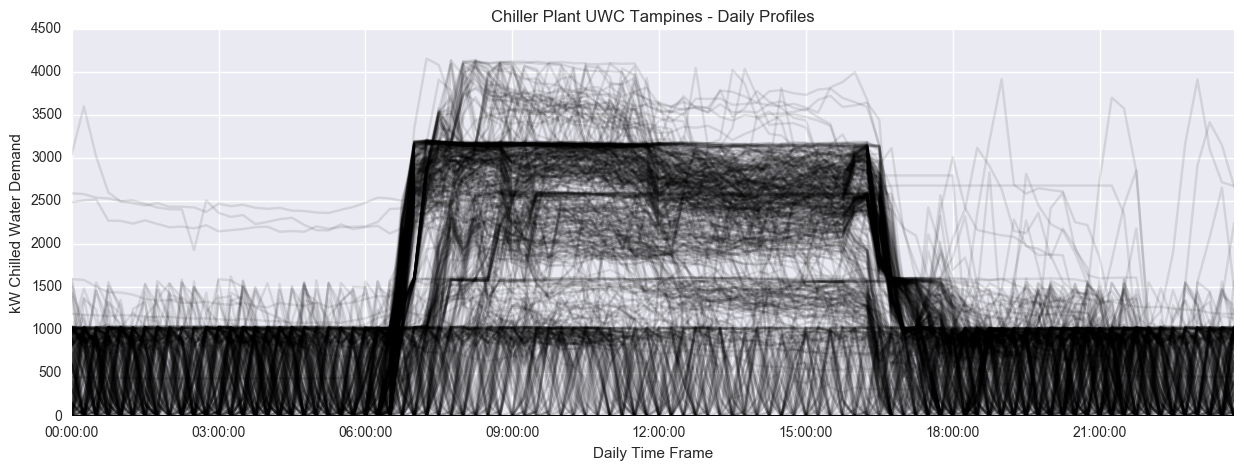

In [65]:
df_pivot.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=np.arange(0, 86400, 10800))
plt.title("Chiller Plant UWC Tampines - Daily Profiles")
plt.xlabel("Daily Time Frame")
plt.ylabel("kW Chilled Water Demand")
plt.savefig("./graphics/rawdata_chillerkW_dailyprofiles.png")

Looks like we have quite a few pretty common patterns and a few outlier patterns where we have some consumption in the early morning and late night hours.

How can we divide this dataset up according to conventional wisdom -- the first obvious choice is to divide between weekdays vs. the weekends. 

Let's look at weekdays first:

In [66]:
df['Weekday'] = df.index.map(lambda t: t.date().weekday())

In [67]:
df.head()

,CP_TotalChiller_kW,Date,Time,Weekday
2012-07-12 00:00:00,0.0,2012-07-12,00:00:00,3
2012-07-12 00:15:00,0.0,2012-07-12,00:15:00,3
2012-07-12 00:30:00,0.0,2012-07-12,00:30:00,3
2012-07-12 00:45:00,0.0,2012-07-12,00:45:00,3
2012-07-12 01:00:00,0.0,2012-07-12,01:00:00,3


In [68]:
df_pivot_weekday = pd.pivot_table(df[(df.Weekday < 5)], values='CP_TotalChiller_kW', index='Date', columns='Time')

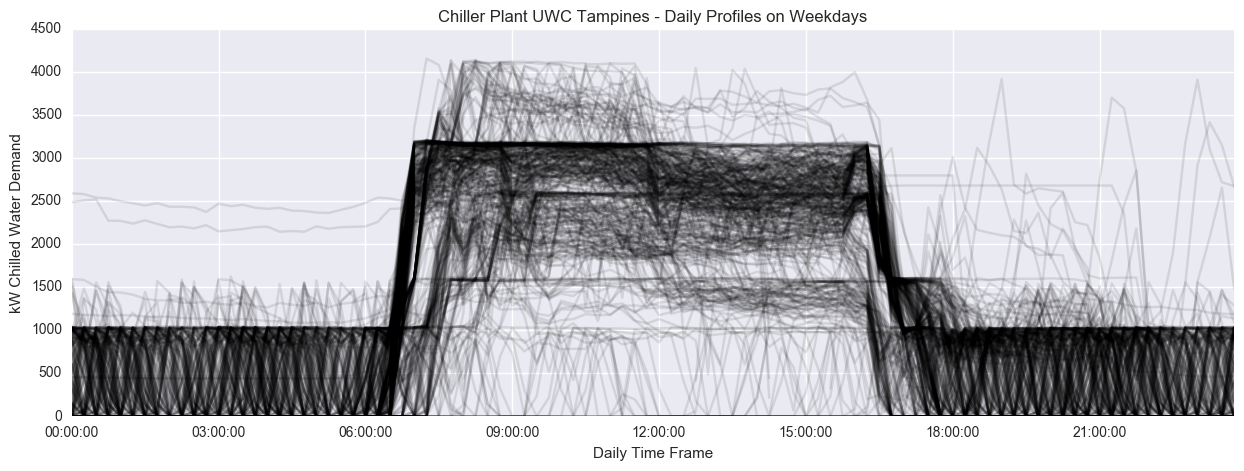

In [70]:
df_pivot_weekday.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=np.arange(0, 86400, 10800))
plt.title("Chiller Plant UWC Tampines - Daily Profiles on Weekdays")
plt.xlabel("Daily Time Frame")
plt.ylabel("kW Chilled Water Demand")
plt.savefig("./graphics/rawdata_chillerkW_dailyprofiles_weekday.png")

Now weekends:

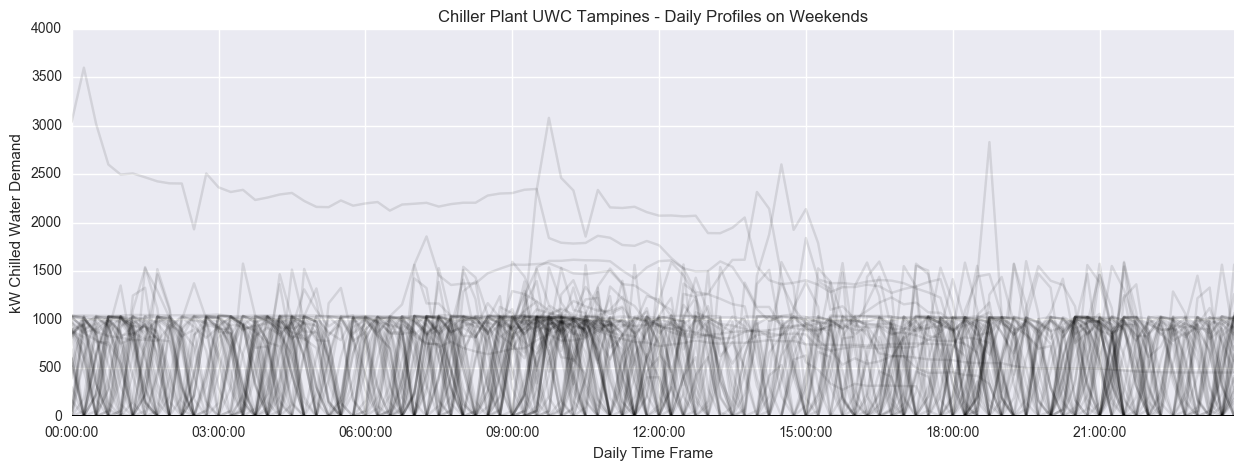

In [72]:
df_pivot_weekend = pd.pivot_table(df[(df.Weekday > 5)], values='CP_TotalChiller_kW', index='Date', columns='Time')
df_pivot_weekend.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=np.arange(0, 86400, 10800))
plt.title("Chiller Plant UWC Tampines - Daily Profiles on Weekends")
plt.xlabel("Daily Time Frame")
plt.ylabel("kW Chilled Water Demand")
plt.savefig("./graphics/rawdata_chillerkW_dailyprofiles_weekend.png")

It can be noticed that there is still quite a bit of anomolous-looking daily profiles that are not characterized only by the day of the week -- this can be due to holidays, weird schedules, or actually deviant behaviour.

Rather than asking UWC what all of their extracurricular activites are, etc -- let's try using the DayFilter process to divide the data into frequent or infrequent simply according to the patterns.

##Symbolic Aggregate ApproXimation (SAX) Transformation

To understand the typical daily profiles, we first use a very simple time-series approximation transformation step called [SAX](http://www.cs.ucr.edu/~eamonn/SAX.htm). You can read in [our paper](https://www.researchgate.net/publication/266616977_Automated_daily_pattern_filtering_of_measured_building_performance_data) all of the detail about the *how* and *why*. Here we will simply show how its calculated.

First, we set the alphabet size, $a$, and the number of window, $w$ parameters for the algorithm. The default is 3 and 4 respectively. The $w$ parameter is defined here by the lenth of the subsequence window -- in this case, 6 hours.

In [73]:
a = 3
w = '6h'

Now we define a few functions that will convert time series to SAX -- please note that this is a very simplifed implementation of SAX and only works with non-moving chunked daily profiles.

In [74]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    #数据透视表
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

Let's feed out `df` into these functions and get the SAX word patterns out

In [101]:
df_pivot

Time,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2012-07-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2012-07-14,0.000000,0.000000,0.000000,431.949999,1022.760000,976.050000,502.180000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2012-07-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2012-07-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2012-07-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2012-07-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2012-07-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2012-07-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,150.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [98]:
type(df_forSAX)

pandas.core.series.Series

In [95]:
df_forSAX = df.CP_TotalChiller_kW
zpivot, SAXstrings = SAXizer(df_forSAX, a, w)

D:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


In [96]:
SAXstrings

Date
2012-07-12    abba
2012-07-13    abba
2012-07-14    aaaa
2012-07-15    aaaa
2012-07-16    abba
2012-07-17    abba
2012-07-18    abba
2012-07-19    abba
2012-07-20    abba
2012-07-21    aaaa
2012-07-22    aaaa
2012-07-23    abba
2012-07-24    abba
2012-07-25    abba
2012-07-26    acca
2012-07-27    acca
2012-07-28    aaaa
2012-07-29    aaaa
2012-07-30    acca
2012-07-31    acca
2012-08-01    acca
2012-08-02    acca
2012-08-03    acca
2012-08-04    abca
2012-08-05    bcca
2012-08-06    bcca
2012-08-07    acca
2012-08-08    acca
2012-08-09    aaab
2012-08-10    acca
              ... 
2014-03-11    acca
2014-03-12    acca
2014-03-13    acca
2014-03-14    acca
2014-03-15    abba
2014-03-16    abba
2014-03-17    acca
2014-03-18    accb
2014-03-19    accb
2014-03-20    acca
2014-03-21    accb
2014-03-22    bbca
2014-03-23    aaaa
2014-03-24    accb
2014-03-25    acca
2014-03-26    accb
2014-03-27    acca
2014-03-28    acca
2014-03-29    abaa
2014-03-30    aaaa
2014-03-31    acba
2014-04

In [25]:
SAXstrings.head(15)

Date
2012-07-12    abba
2012-07-13    abba
2012-07-14    aaaa
2012-07-15    aaaa
2012-07-16    abba
2012-07-17    abba
2012-07-18    abba
2012-07-19    abba
2012-07-20    abba
2012-07-21    aaaa
2012-07-22    aaaa
2012-07-23    abba
2012-07-24    abba
2012-07-25    abba
2012-07-26    acca
dtype: object

In [26]:
patterncount = SAXstrings.value_counts()

In [27]:
patterncount

acca    275
aaaa    106
accb     72
abaa     51
abba     50
acba     39
bcca      8
aaba      8
bbba      5
abca      4
bccb      4
ccca      2
accc      2
abbb      2
aaab      2
cccc      1
ccba      1
cccb      1
bcba      1
bccc      1
bbaa      1
abab      1
dtype: int64

In [100]:
zpivot

Time,00:00:00,06:00:00,12:00:00,18:00:00
Date,,,,
2012-07-12,a,b,b,a
2012-07-13,a,b,b,a
2012-07-14,a,a,a,a
2012-07-15,a,a,a,a
2012-07-16,a,b,b,a
2012-07-17,a,b,b,a
2012-07-18,a,b,b,a
2012-07-19,a,b,b,a
2012-07-20,a,b,b,a


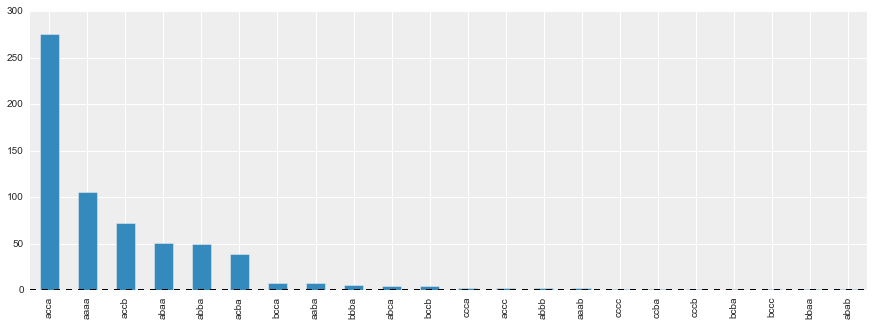

In [28]:
patterncount.plot(kind='bar', figsize=(15,5))

The daily profiles have been transformed to one of multiple SAX Word 'patterns' -- this is a really rough aggregation of each day but it will capture the major types of aggregations.

Let's combine the raw data and the SAX words and visualize the profiles contained within some of the pattern types

In [29]:
df_RawAndSAX = pd.concat([df_pivot, pd.DataFrame(SAXstrings, columns=['SAXstring'])], axis=1)

In [30]:
pattern = "acca"

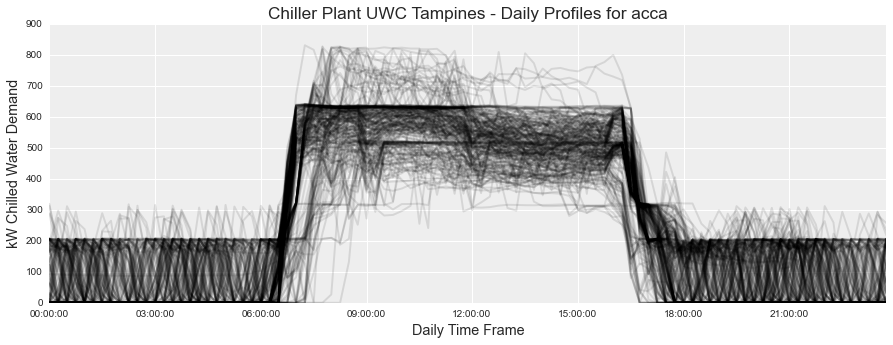

In [31]:
pattern_profiles = df_RawAndSAX[df_RawAndSAX.SAXstring == pattern].drop(['SAXstring'],axis=1)
pattern_profiles.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=arange(0, 86400, 10800))
plt.title("Chiller Plant UWC Tampines - Daily Profiles for "+pattern)
plt.xlabel("Daily Time Frame")
plt.ylabel("kW Chilled Water Demand")
plt.savefig("./graphics/rawdata_chillerkW_dailyprofiles_"+pattern+".png")

Let's look at these profiles as a heatmap

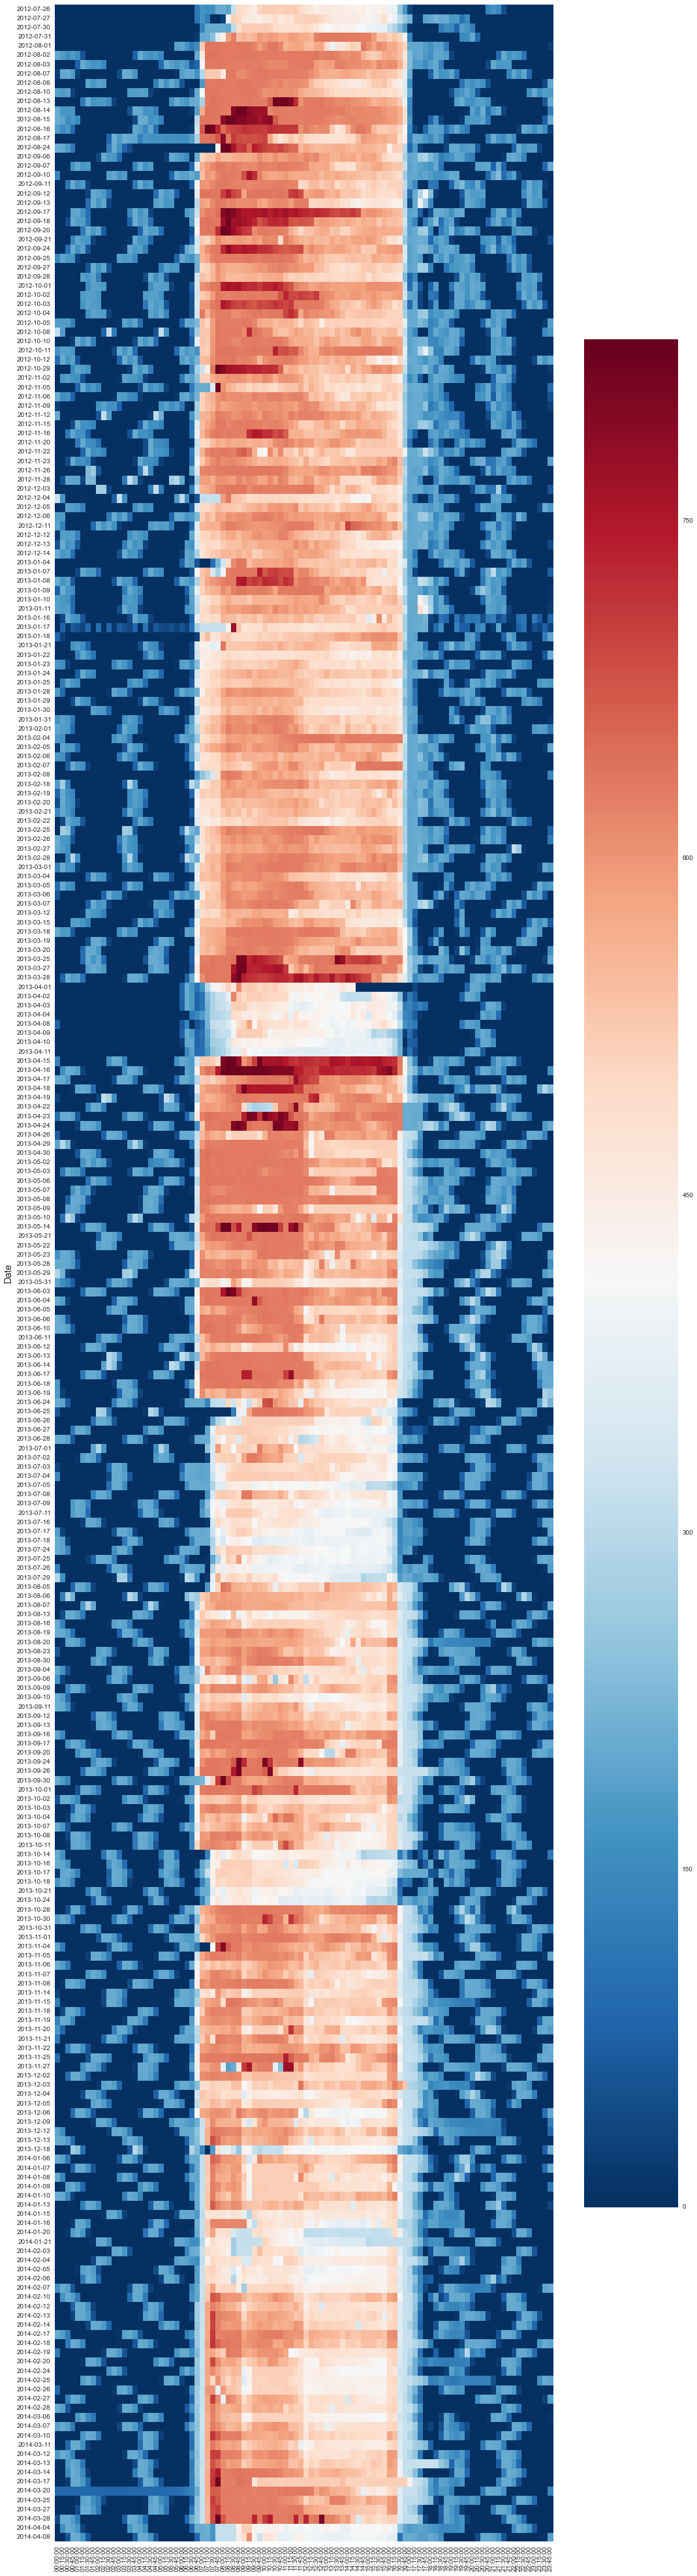

In [32]:
patterns = df_RawAndSAX[df_RawAndSAX.SAXstring == pattern].drop(['SAXstring'],axis=1)
f, ax = plt.subplots(figsize=(15, len(patterns)*0.2))
sns.heatmap(patterns,linewidths=0, cmap="RdBu_r")
f.tight_layout()
plt.savefig("./graphics/rawdata_chillerkW_heatmap_"+pattern+".png")

Let's pull out one of the less frequent patterns

In [33]:
pattern = "acba"

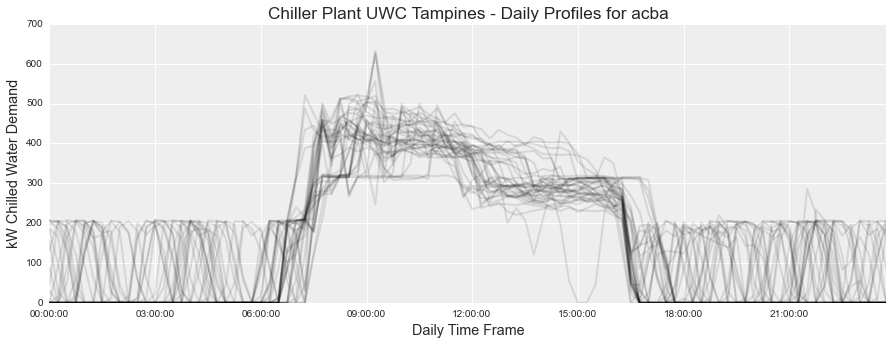

In [34]:
pattern_profiles = df_RawAndSAX[df_RawAndSAX.SAXstring == pattern].drop(['SAXstring'],axis=1)
pattern_profiles.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=arange(0, 86400, 10800))
plt.title("Chiller Plant UWC Tampines - Daily Profiles for "+pattern)
plt.xlabel("Daily Time Frame")
plt.ylabel("kW Chilled Water Demand")
plt.savefig("./graphics/rawdata_chillerkW_dailyprofiles_"+pattern+".png")

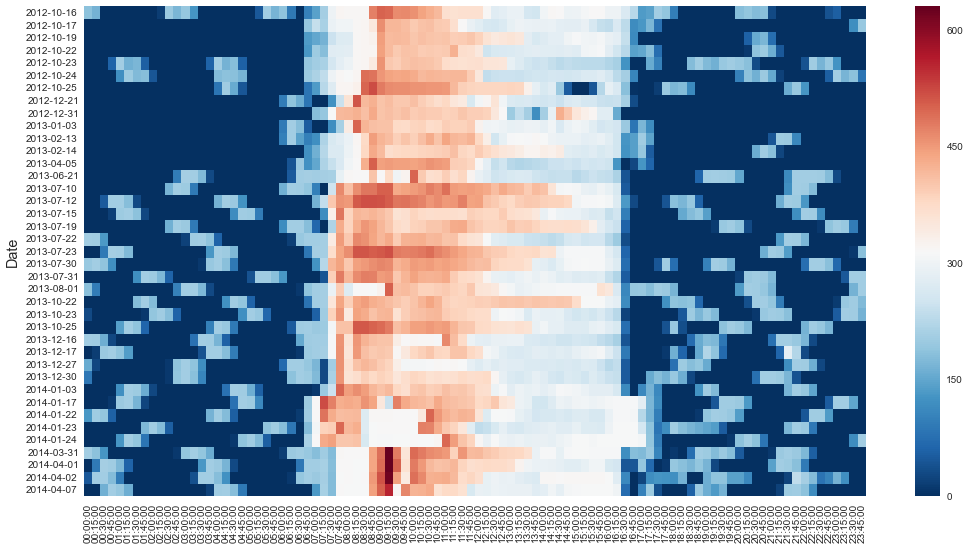

In [39]:
patterns = df_RawAndSAX[df_RawAndSAX.SAXstring == pattern].drop(['SAXstring'],axis=1)
f, ax = plt.subplots(figsize=(15, len(patterns)*0.2))
sns.heatmap(patterns, linewidths=0, cmap="RdBu_r")
f.tight_layout()
plt.savefig("./graphics/rawdata_chillerkW_heatmap_"+pattern+".png")

##Partition patterns into motif and discord candidates

Here we use a heuristic to divide the patterns into motif and discord candidates based on the percentage frequency.

In [40]:
#Percentage of outlier sizes
binsizethreshold = 0.01

In [41]:
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

acca    275
aaaa    106
accb     72
abaa     51
abba     50
acba     39
bcca      8
aaba      8
dtype: int64

In [42]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords

bbba    5
abca    4
bccb    4
ccca    2
accc    2
abbb    2
aaab    2
cccc    1
ccba    1
cccb    1
bcba    1
bccc    1
bbaa    1
abab    1
dtype: int64

Let's visualize only the discord patterns

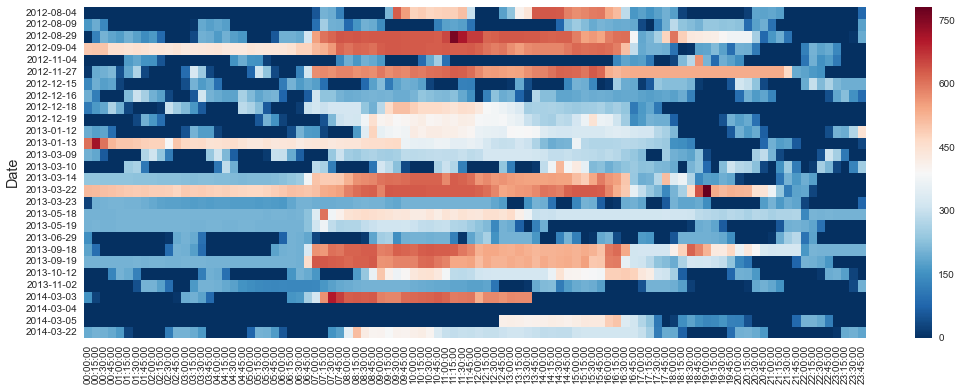

In [43]:
patterns = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(discords.index))].drop(['SAXstring'],axis=1)
f, ax = plt.subplots(figsize=(15, len(patterns)*0.2))
sns.heatmap(patterns, linewidths=0, cmap="RdBu_r")
f.tight_layout()
plt.savefig("./graphics/rawdata_chillerkW_heatmap_discords.png")

In [44]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(motifs.index))]
discorddata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(discords.index))].dropna()

In [45]:
discorddata.to_csv("DiscordProfiles.csv")
motifdata.to_csv("MotifProfiles.csv")

We'll use these profiles in the next 2 notebooks to investigate the discords and further aggregate the motifs